# Степенные преобразования данных

### Когда применяются?

1. При наличии значительно смещённых данных
2. В некоторых случаях для улучшения визуализации данных
3. В некоторых случаях для улучшения интерпретируемости

Решение о том, какое преобразование применять, и применять ли вообще, должно диктоваться конкретным видом статистического анализа, который будет произведён на даных. Например, простой способ построить 95% доверительный интервал для среднего значения по популяции - взять среднее значение по выборке плюс минус две величины стандартной ошибки. Однако множитель "два" здесь подходит только для случаев, когда данные подчиняются Нормальному распределению, и применяется когда выборочное среднее меняется более-менее Нормально. Теорема центрального предела говорит, что выборочное среднее меняется Нормально во многих случаях, когда размер выборки достаточно велик. Однако **если генеральная совокупность сильно смещена**, а размер выборки не слишком велик, то приближение, данное теоремой центрального предела, может оказаться весьма посредственным, и как следствие - доверительный интервал, построенный нами, скорее всего будет иметь неверное покрытие (wrong coverage probability). Поэтому, **если имеются свидетельства о том, что данные существенно смещены**, то нередко применяют преобразование данных, порождающее более симметричное распределение. А уже потом прикидывают доверительный интервал. После этого доверительный интервал можно преобразовать обратно в исходную шкалу путём трансформации, обратной той, которая была применена к данным.

Также данные могут быть преобразованы, чтобы их было легче визуализировать. Например, у нас есть scatterplot, на котором точки представляют собой страны мира, а оси х и у - население страны в миллионах человек и площадь в десятках тысяч квадратных километров, как на рисунке справа. Видим, что большая часть стран мира имеют небольшое население и площадь, так что большая часть дата-точек собралась в левой нижней части графика. Несколько стран с большим населением и площадью разбросаны в других частях графика. Простое изменение магнитуды шкал (rescaling units) на тысячи квадратных километров или на миллионы человек не изменит этой картины. Однако логарифмическое преобразование обеих переменных, площади и населения, приведёт к более равномерному распределению точек по графику.

Третья причина: улучшение интерпретируемости данных. Это может понадобиться даже в случаях, когда никакой формальный статистический анализ на данных проводиться не будет. Например, мы сравниваем автомобили по их экономичности. Данные могут быть представлены как "километры на литр" или "мили на галлон". Однако если мы хотим посчитать, насколько больше топлива потребуется одному автомобилю для путешествия из А в В чем другому, гораздо удобнее будет воспользоваться обратной трансформацией данных вида $f(x) = \frac{1}{x}$, которая превратит данные в "километры на литр" или в "галлоны на милю" соответственно.


## Логарифмическое преобразование (Log Transform)

Data: [194  37 113 ...,  23   5  99]


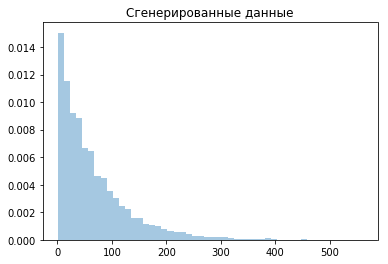

Дисперсия сгенерированных данных:   4253.68612831


In [194]:
%matplotlib inline

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

SAMPLE_SIZE = 10000
# Сгенерируем смещённые влево данные из геометрического распределения
data = np.random.geometric(p=0.015, size=SAMPLE_SIZE)
print('Data:', data)
# Также разобьём их на дизайн-матрицу (вектор в данном случае) X и респонс-вектор y:
X = np.array(data).reshape(-1, 1)
y = [(X==el).sum() for el in X]
plt.clf()
sns.distplot(data, kde=False, norm_hist=True)
plt.title('Сгенерированные данные')
plt.show()
print('Дисперсия сгенерированных данных:  ', np.var(data))

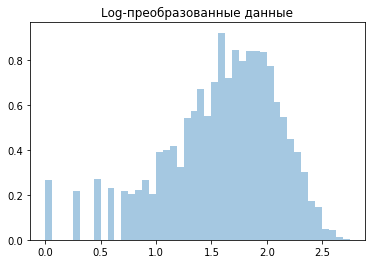

Дисперсия Log-преобразованных данных:   0.27237878653


In [195]:
# Проведём логарифмическое преобразование данных и рассмотрим результат:
transformed_data = np.log10(data)
plt.clf()
sns.distplot(transformed_data, kde=False, norm_hist=True)
plt.title('Log-преобразованные данные')
plt.show()
print('Дисперсия Log-преобразованных данных:  ', np.var(transformed_data))

Разумеется, частоты конкретных значений x при этом остаются неизменными:

In [196]:
print((data == 1).sum(),   ' = ', (transformed_data == 0).sum())
print((data == 10).sum(),  ' = ', (transformed_data == 1).sum())
print((data == 100).sum(), '  = ', (transformed_data == 2).sum())

168  =  168
122  =  122
23   =  23


# Box-Cox

Автоматически подбирает оптимальный параметр $\lambda$ 

λ = 0.238809293563


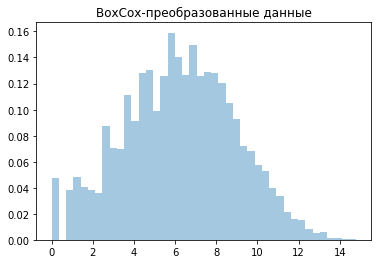

Дисперсия преобразованных данных:   7.40123312551


In [197]:
from scipy import stats
plt.clf()
transformed_data, lmbd = stats.boxcox(data)
sns.distplot(transformed_data, kde=False, norm_hist=True)
print('λ =', lmbd)
plt.title('BoxCox-преобразованные данные')
plt.show()
print('Дисперсия преобразованных данных:  ', np.var(transformed_data))

<br><br><br><br>
# Первый случай: преобразование для обучения

Улучшат ли преобразования данных качество работы линейной регрессии? Возможно, за счёт введения гомоскедастичности, при том что исходные данные довольно гетероскедастичны.

Результат 10-fold-CV линейной регрессии: 608.140271379
MSE на тренировочном наборе:             607.546029824


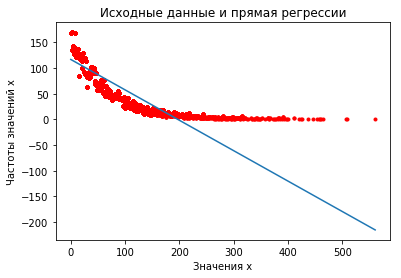

In [202]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

def experiment(X, y, title='Title', xlabel='x', ylabel='y'):
    # Обучим линейную регрессию и оценим результат:
    lr = LinearRegression()
    lr.fit(X, y)
    y_pred = lr.predict(X)
    print('Результат 10-fold-CV линейной регрессии:', 
          np.mean(cross_val_score(lr, X, y, cv=10, scoring='neg_mean_squared_error') * -1))
    print('MSE на тренировочном наборе:            ', mean_squared_error(y, y_pred))

    # Отобразим исходные данные и прямую регрессии:
    plt.clf()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(X, y, '.', c = 'r')
    x_values = np.linspace(0, max(X) + 0.1, 2)
    y_values = lr.coef_[0] * x_values + lr.intercept_
    plt.plot(x_values, y_values, ls='-')
    plt.show()
    
experiment(X, y, 'Исходные данные и прямая регрессии', 'Значения x', 'Частоты значений x')

Теперь проведём Log-преобразование X и рассмотрим результат:

Результат 10-fold-CV линейной регрессии: 243.906578552
MSE на тренировочном наборе:             243.776777108


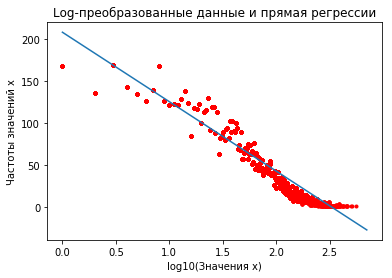

In [204]:
experiment(np.log10(X), y, 'Log-преобразованные данные и прямая регрессии',
           'log10(Значения x)', 'Частоты значений x')

### А что если провести аналогичную трансформацию y-оси?

Результат 10-fold-CV линейной регрессии: 0.0548530265984
MSE на тренировочном наборе:             0.283556595197


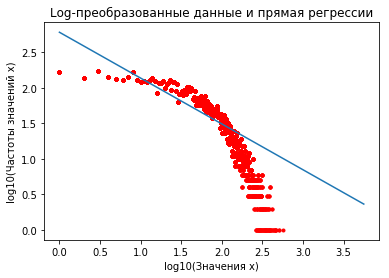

In [205]:
# Построим дизайн-матрицу X и респонс-вектор y:
X = np.log10(data).reshape(-1, 1)
y = [(np.log10(data)==el).sum() for el in X]
# CHANGES:
y = np.log10(y)
# Обучим линейную регрессию и оценим результат:
lr = LinearRegression()
lr.fit(X, y)
print('Результат 10-fold-CV линейной регрессии:', 
      np.mean(cross_val_score(lr, X, y, cv=10, scoring='neg_mean_squared_error') * -1))
print('MSE на тренировочном наборе:            ', mean_squared_error(y, y_pred))
# Отобразим исходные данные и прямую регрессии:
plt.clf()
plt.title('Log-преобразованные данные и прямая регрессии')
plt.xlabel('log10(Значения x)')
plt.ylabel('log10(Частоты значений x)')
plt.plot(X, y, '.', c = 'r')
x_values = np.linspace(0, max(X) + 1, 2)
y_values = lr.coef_[0] * x_values + lr.intercept_
plt.plot(x_values, y_values, ls='-')
plt.show()

**Наблюдения:** видим, что точность предсказания повысилась в силу того, что ось y спрессована из интервала [0, ~180] в интервал [0, ~2.5]. Магнитуда y уменьшилась примерно в 70 раз, что привело к малым значениям резидуалов.

**Хотя сам по себе fit здесь выглядит значительно хуже, чем на предыдущем графике!** Обратим внимание на хорошую гомоскедастичность предыдущего графика, и на гетероскедастичность этого графика.

Попробуем теперь спрогнозированные значения, исчисляемые сейчас в логарифмической шкале, перевести обратно в изначальную шкалу и замерить ошибку:

In [206]:
# Обязательно: вернёмся к исходной шкале y
y = [(data==el).sum() for el in data]

# Рассмотрим вектор прогнозов для y в логарифмической шкале:
print('Вектор прогнозов для y в логарифмической шкале:\n', y_pred)
# Переведём вектор прогнозов в изначальную шкалу:
y_initial_scale = 10 ** y_pred
print('Вектор прогнозов для y в исходной шкале:\n', y_initial_scale)
# Проверим результат:
print(10**y_pred[1], '=', y_initial_scale[1])
# Измерим тренировочную ошибку:
print('Тренировочная точность в исходной шкале:', mean_squared_error(y, y_initial_scale))

Вектор прогнозов для y в логарифмической шкале:
 [ 2.38507778  1.80239426  1.44592071 ...,  1.68765988  1.74245723
  2.32346217]
Вектор прогнозов для y в исходной шкале:
 [ 242.70447045   63.44454131   27.92034034 ...,   48.71468335   55.26589829
  210.60184336]
63.4445413119 = 63.4445413119
Тренировочная точность в исходной шкале: 10531.4604199


Видим, что метрика MSE на тренировочной выборке **ухудшилась** в изначальных единицах y. Очевидно, это связано с тем, что fit который мы получили при логарифмически преобразованной шкале y получился довольно **плохим**. Поэтому неудивительно, что при переходе к исходной шкале y мы получили худший результат. Если бы fit в log-шкале y получился бы лучше, то возможно, что и конечный результат получился бы лучше. 

Как понять, насколько хорош fit, если нет возможности начертить х и y на графике? Если x это матрица, к примеру. Тогда, наверное, поможет только эмпирическое сравнение: провести подгонку на исходной шкале y, затем - подгонку на логарифмической шкале y, и затем сравнить полученные результаты.

## Рассмотрим BoxCox-преобразование

Результат 10-fold-CV линейной регрессии: 160.914495192
MSE на тренировочном наборе:             160.875771452


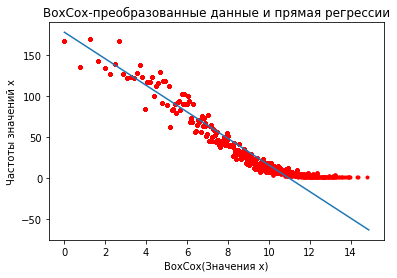

In [223]:
X = np.array(data)
y = [(X==el).sum() for el in X]
experiment(stats.boxcox(X)[0].reshape(-1, 1), y, 'BoxCox-преобразованные данные и прямая регрессии',
           'BoxCox(Значения x)', 'Частоты значений x')

Как видим, подгонка получилась ещё плотнее. За счёт чего это происходит? Возможно, за счёт повышения гомоскедастичности?